In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split


In [2]:
data = torch.load('TrainingDataset/Kcat_Enzymatic_reaction.pt',weights_only=False)
data.head()

,ECNumber,Organism,Smiles,Substrate,Sequence,Raw Kd,Unit,Log Kd
0,4.2.3.4,Actinidia chinensis,C(C(C(C(COP(=O)(O)O)O)O)O)C(=O)C(=O)O,3-deoxy-D-arabino-heptulosonic acid 7-phosphate,MAAFSLSAKQILSPSTHRPSLSKTTTADSSLRFRNPHSLSLRCSSL...,20.1000,s^(-1),1.303196
1,4.2.3.4,Aspergillus nidulans,C(C(C(C(COP(=O)([O-])[O-])O)O)O)C(=O)C(=O)[O-],3-deoxy-D-arabino-heptulosonate 7-phosphate,MSNPTKISILGRESIIADFGLWRNYVAKDLISDCSSTTYVLVTDTN...,6.8000,s^(-1),0.832509
2,4.2.3.4,Neurospora crassa,C(C(C(C(COP(=O)(O)O)O)O)O)C(=O)C(=O)O,3-deoxy-D-arabino-heptulosonic acid 7-phosphate,MAEPISNPTRINILGKDNIIIDHGIWLNFVAQDLLQNIKSSTYILI...,19.0000,s^(-1),1.278754
3,2.1.1.255,Streptomyces coelicolor,C[S+](CCC(C(=O)[O-])N)CC1C(C(C(O1)N2C=NC3=C(N=...,S-Adenosyl-L-methionine,MTTETTTATATAKIPAPATPYQEDIARYWNNEARPVNLRLGDVDGL...,0.0075,s^(-1),-2.124939
4,2.1.1.255,Streptomyces coelicolor,CC(=CCCC(=C(C)COP(=O)(O)OP(=O)(O)O)C)C,(E)-2-Methylgeranyl diphosphate,MTTETTTATATAKIPAPATPYQEDIARYWNNEARPVNLRLGDVDGL...,0.0390,s^(-1),-1.408935


In [3]:
from transformers import AutoTokenizer, AutoModel
import torch

# Load ChemRoBERTa tokenizer and model
chem_tokenizer = AutoTokenizer.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")
chem_model = AutoModel.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")

# Load ESM2 tokenizer and model
esm_tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D")
esm_model = AutoModel.from_pretrained("facebook/esm2_t6_8M_UR50D")

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
def extract_chem_features(smiles):
    """Extract ChemRoBERTa features from SMILES."""
    try:
        tokens = chem_tokenizer(smiles, return_tensors="pt", padding=True, truncation=True)
        with torch.no_grad():
            embeddings = chem_model(**tokens).last_hidden_state.mean(dim=1).squeeze().numpy()
        return embeddings
    except:
        return np.zeros(768)  # Return zero vector if extraction fails

def extract_esm_features(sequence):
    """Extract ESM2 features from protein sequence."""
    try:
        tokens = esm_tokenizer(sequence, return_tensors="pt", padding=True, truncation=True)
        with torch.no_grad():
            embeddings = esm_model(**tokens).last_hidden_state.mean(dim=1).squeeze().numpy()
        return embeddings
    except:
        return np.zeros(768)  # Return zero vector if extraction fails

In [5]:
# Extract unique mols and proteins
unique_mols = data[['Smiles']].drop_duplicates()
unique_proteins = data[['Sequence']].drop_duplicates()

In [6]:
len(unique_mols), len(unique_proteins)

(2706, 7857)

In [7]:
# Extract features for unique mols
tqdm.pandas()  # Enable progress bar for pandas
unique_mols['metabolite_features'] = unique_mols['Smiles'].progress_apply(extract_chem_features)

100%|██████████| 2706/2706 [01:31<00:00, 29.49it/s]


In [8]:
# Extract features for unique proteins
unique_proteins['protein_features'] = unique_proteins['Sequence'].progress_apply(extract_esm_features)

100%|██████████| 7857/7857 [11:55<00:00, 10.98it/s]  


In [9]:
# Merge features back into the combined dataframe
data = data.merge(unique_mols, on='Smiles', how='left')
data = data.merge(unique_proteins, on='Sequence', how='left')

In [10]:
# adding 1e-9 to prevent error when doing logarithm
data['label'] = -np.log10(data['Raw Kd'] + 1e-9)

In [11]:
# Define dataset
class MPI_Dataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        return {
            'metabolite_features': torch.tensor(np.asarray(row['metabolite_features'], dtype=np.float32)),
            'protein_features': torch.tensor(np.asarray(row['protein_features'], dtype=np.float32)),
            'label': torch.tensor(float(row['label']), dtype=torch.float32),
        }

In [12]:
data.columns

Index(['ECNumber', 'Organism', 'Smiles', 'Substrate', 'Sequence', 'Raw Kd',
       'Unit', 'Log Kd', 'metabolite_features', 'protein_features', 'label'],
      dtype='object')

In [13]:
# Load data
# Assuming `combined_df` is a pandas DataFrame containing all necessary columns


#嘗試cold split
train_df, temp_df = train_test_split(data, test_size=0.3, shuffle=True, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, shuffle=True, random_state=42)

train_X = np.array([
    np.concatenate([m, p])
    for m, p in zip(train_df['metabolite_features'], train_df['protein_features'])
])
train_y = train_df['label']
val_X = np.array([
    np.concatenate([m, p])
    for m, p in zip(val_df['metabolite_features'], val_df['protein_features'])
])
val_y = val_df['label']
test_X = np.array([
    np.concatenate([m, p])
    for m, p in zip(test_df['metabolite_features'], test_df['protein_features'])
])
test_y = test_df['label']

'''
from sklearn.model_selection import PredefinedSplit
split_index = [-1]*len(train_X) + [0]*len(val_X)
X = np.concatenate((train_X,val_X),axis=0)
y = np.concatenate((train_y,val_y),axis=0)
pds = PredefinedSplit(test_fold=split_index)

'''

'''
train_dataset = MPI_Dataset(train_df)
val_dataset = MPI_Dataset(val_df)
test_dataset = MPI_Dataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)
'''

'\ntrain_dataset = MPI_Dataset(train_df)\nval_dataset = MPI_Dataset(val_df)\ntest_dataset = MPI_Dataset(test_df)\n\ntrain_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)\nval_loader = DataLoader(val_dataset, batch_size=32)\ntest_loader = DataLoader(test_dataset, batch_size=32)\n'

In [14]:
#model initialization
import catboost as cat
ca = cat.CatBoostRegressor()

In [15]:
'''
#Grid search
#ref: https://xgboost.readthedocs.io/en/stable/parameter.html
from sklearn.model_selection import GridSearchCV
param_grid = dict(
    max_depth = [5,10,15,20,None],
    n_estimators = [50,100,150,200]
)
regressor = GridSearchCV(estimator = xgb, param_grid = param_grid, cv = pds, verbose = 3, n_jobs = -1)
'''
#Train the model
ca.fit(train_X,train_y)

Learning rate set to 0.060556
0:	learn: 1.5036865	total: 110ms	remaining: 1m 49s
1:	learn: 1.4935330	total: 139ms	remaining: 1m 9s
2:	learn: 1.4835253	total: 164ms	remaining: 54.6s
3:	learn: 1.4741422	total: 190ms	remaining: 47.4s
4:	learn: 1.4661426	total: 216ms	remaining: 43s
5:	learn: 1.4588495	total: 241ms	remaining: 40s
6:	learn: 1.4511848	total: 268ms	remaining: 38s
7:	learn: 1.4432858	total: 293ms	remaining: 36.4s
8:	learn: 1.4355709	total: 320ms	remaining: 35.3s
9:	learn: 1.4290797	total: 344ms	remaining: 34.1s
10:	learn: 1.4225164	total: 369ms	remaining: 33.2s
11:	learn: 1.4167957	total: 393ms	remaining: 32.4s
12:	learn: 1.4105612	total: 417ms	remaining: 31.7s
13:	learn: 1.4050181	total: 443ms	remaining: 31.2s
14:	learn: 1.3982485	total: 468ms	remaining: 30.8s
15:	learn: 1.3922784	total: 492ms	remaining: 30.3s
16:	learn: 1.3870485	total: 515ms	remaining: 29.8s
17:	learn: 1.3808661	total: 541ms	remaining: 29.5s
18:	learn: 1.3765246	total: 565ms	remaining: 29.2s
19:	learn: 1.372

In [16]:
# Train
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error, explained_variance_score
from scipy.stats import pearsonr

y_train_pred = ca.predict(train_X)

train_mse = mean_squared_error(train_y, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_mae = mean_absolute_error(train_y, y_train_pred)
train_r2 = r2_score(train_y, y_train_pred)
train_pearson_corr, _ = pearsonr(train_y, y_train_pred)
train_median_ae = median_absolute_error(train_y, y_train_pred)
train_explained_var = explained_variance_score(train_y, y_train_pred)

In [17]:
# Validation
y_val_pred = ca.predict(val_X)

val_mse = mean_squared_error(val_y, y_val_pred)
val_rmse = np.sqrt(val_mse)
val_mae = mean_absolute_error(val_y, y_val_pred)
val_r2 = r2_score(val_y, y_val_pred)
val_pearson_corr, _ = pearsonr(val_y, y_val_pred)
val_median_ae = median_absolute_error(val_y, y_val_pred)
val_explained_var = explained_variance_score(val_y, y_val_pred)



In [18]:
#Choose the best model and test its performance

#best_model = regressor.best_estimator_
#best_params = regressor.best_params_
#print('Best Hyperparameters:',best_params)

# Test
y_test_pred = ca.predict(test_X)


test_mse = mean_squared_error(test_y, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(test_y, y_test_pred)
test_r2 = r2_score(test_y, y_test_pred)
test_pearson_corr, _ = pearsonr(test_y, y_test_pred)
test_median_ae = median_absolute_error(test_y, y_test_pred)
test_explained_var = explained_variance_score(test_y, y_test_pred)


print(f"Test MSE: {test_mse:.4f}, MAE: {test_mae:.4f}, R-square: {test_r2:.4f}")

Test MSE: 1.1248, MAE: 0.7707, R-square: 0.5001


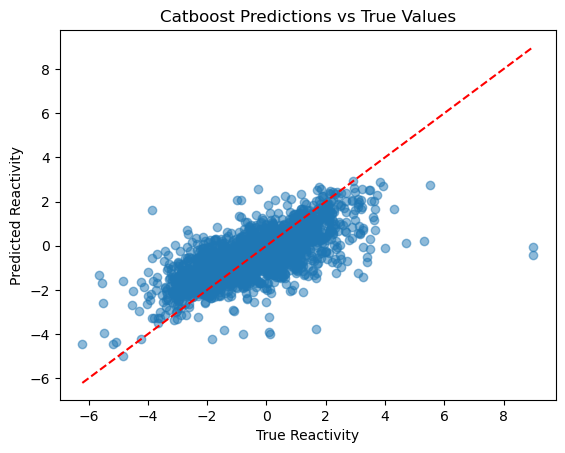

In [19]:
# Plot the performance
import matplotlib.pyplot as plt

plt.scatter(test_y, y_test_pred, alpha=0.5)
plt.xlabel("True Reactivity")
plt.ylabel("Predicted Reactivity")
plt.title("Catboost Predictions vs True Values")
plt.plot([test_y.min(), test_y.max()], [test_y.min(), test_y.max()], 'r--')
plt.show()


In [20]:
# append the performance to the csv file
df = {
    'Model':['CatBoost','CatBoost','CatBoost'],
    'Dataset':['Train','Validation','Test'],
    'MSE':[train_mse,val_mse,test_mse],
    'RMSE':[train_rmse,val_rmse,test_rmse],
    'MAE':[train_mae,val_mae,test_mae],
    'R2':[train_r2,val_r2,test_r2],
    'Pearson':[train_pearson_corr,val_pearson_corr,test_pearson_corr],
    'Median_AE':[train_median_ae,val_median_ae,test_median_ae],
    'Explained_VAR':[train_explained_var,val_explained_var,test_explained_var],
    'Dataspliting Mode':['random','random','random']
}
df = pd.DataFrame(df)

df.to_csv('/Users/pinchichen/2025S lab/AI drug project/code/model performance metrics.csv', mode='a', header=False)

In [24]:
# save the model
ca.save_model("trained_model/CatBoost model.json", format="json")

# load the model
#model = CatBoostRegressor()
#model.load_model("catboost_model.cbm"